In [117]:
import warnings
import pandas as pd
import arviz as az

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from libs.model import HGPforecaster
from libs.metrics import calculate_metrics, metrics_to_table
from libs.pre_processing import generate_groups_data
from libs.visual_analysis import visualize_fit, visualize_predict
import matplotlib.pyplot as plt
import seaborn as sns
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')
import re

sns.set_palette("bright")

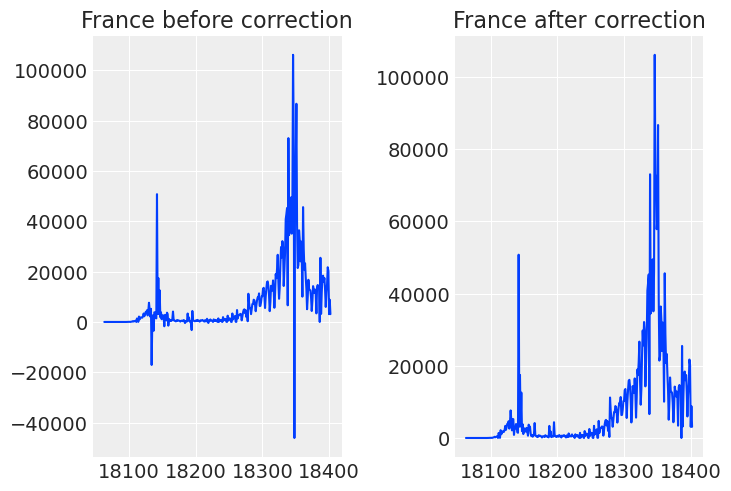

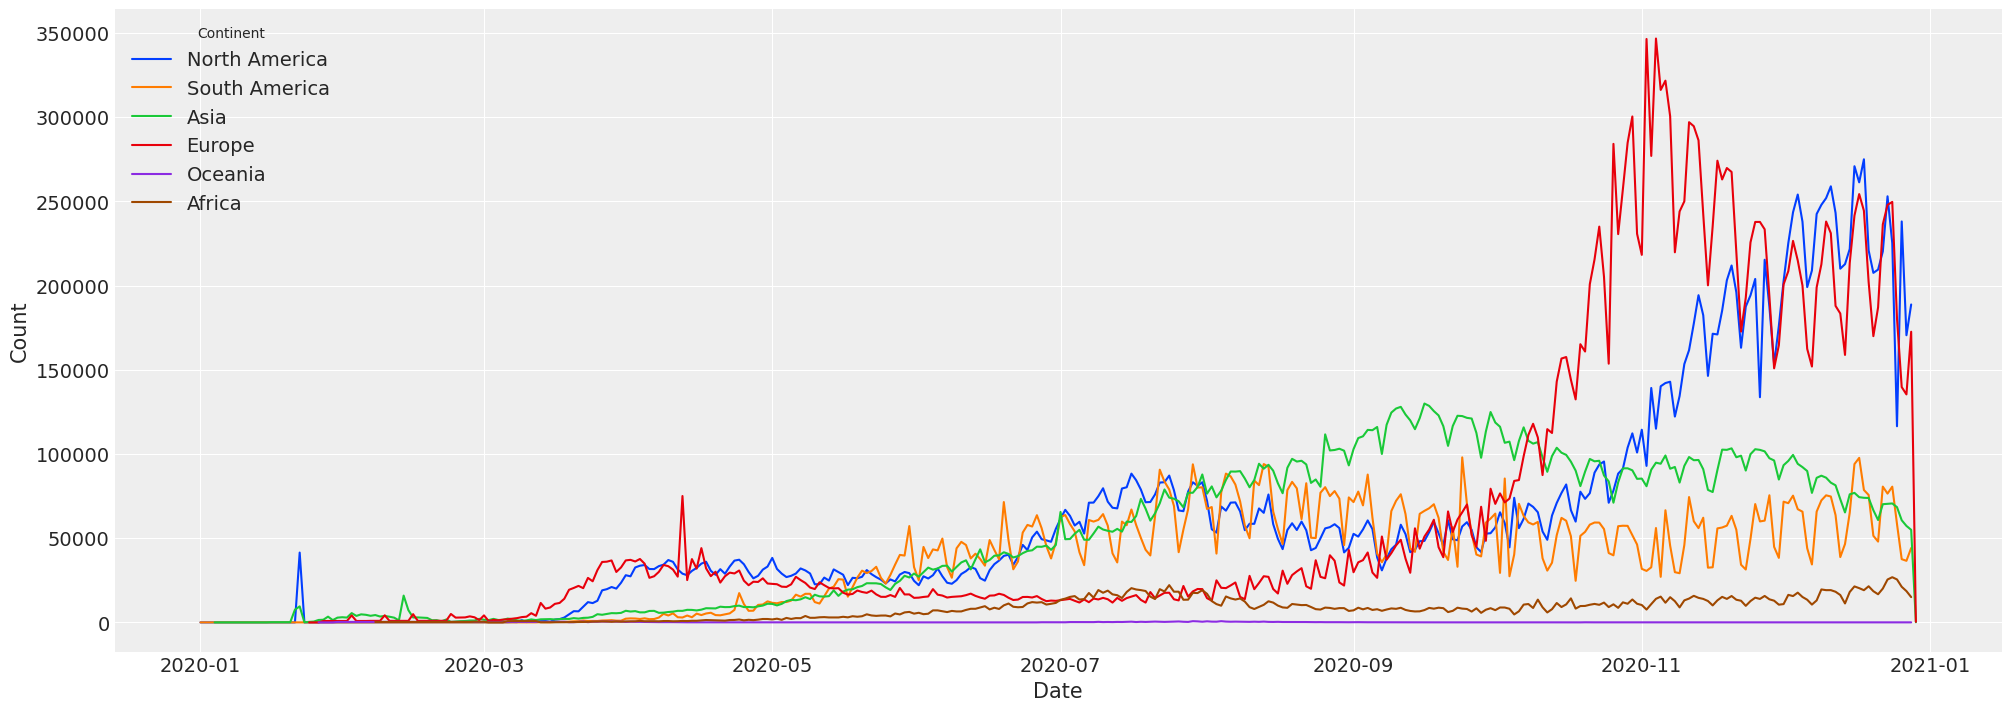

In [137]:
covid19 = pd.read_csv('../data/owid-covid-data.csv')

# remove world
covid19 = covid19.loc[covid19['iso_code'] != 'OWID_WRL']

covid = covid19[['location', 'continent', 'date', 'new_cases']] 
covid.columns = ['Country', 'Continent', 'Date', 'Count']
covid['Date'] = covid['Date'].astype('datetime64[ns]')

covid.groupby(['Date', 'Country']).sum().sort_values(by=['Count'], ascending=False).iloc[0,:]





##### Note: There are inconsistencies in the data which had to do with decisions on the method of counting, see more here https://github.com/CSSEGISandData/COVID-19/issues/2226#issuecomment-614931386.

# See the example of France below.

_, ax = plt.subplots(1,2)

ax[0].plot(covid.loc[covid['Country']=='France']['Count'])
ax[0].set_title('France before correction')

# replacing negative numbers with earlier estimation

covid = covid.assign(Count = lambda x: x.Count.where(x.Count.ge(0)))
covid = covid.fillna(method='ffill')

# France after correction

ax[1].plot(covid.loc[covid['Country']=='France']['Count'])
ax[1].set_title('France after correction')
plt.show()

# Turkey has a very strange value - removing

covid = covid.loc[covid['Country'] != 'Turkey']




_, ax = plt.subplots(1, 1,figsize=(20,7))
sns.lineplot(ax = ax,
             data=covid.groupby(['Date', 'Continent']).sum(),
             x="Date", y="Count", hue="Continent");

raw_text = pd.read_csv('../data/annex_regional_classifications.csv', header=None)
UN_sub_region = []
for i in raw_text[0]:
    UN_sub_region.append(re.split(r'\s{2,}', i))

# Get regions from the UN report
    
df_groups = pd.DataFrame(UN_sub_region)
df_groups.columns = ['Country', 'UN_region', 'UNICEF_region', 'WHO_region', 'MDG_region', 'income']
covid_merge = covid.merge(df_groups, how='left', on ='Country')
covid_merge = covid_merge.dropna()

covid_merge = covid_merge.set_index('Date')
# Some groups have the same names for some regions
covid_merge['UN_region'] = 'UN_' + covid_merge['UN_region'].astype(str)
covid_merge['MDG_region'] = 'MGD_' + covid_merge['MDG_region'].astype(str)


covid_pivot = covid_merge.reset_index().pivot(index='Date',columns=['Continent', 'Country', 'UN_region', 'UNICEF_region', 'WHO_region', 'MDG_region', 'income'], values='Count')
covid_pivot = covid_pivot.fillna(0)

groups_input = {
    'Continent': [0],
    'Country': [1],
    'UN_region': [2],
    'UNICEF_region': [3],
    'WHO_region': [4],
    'MDG_region': [5],
    'income': [6]
}

In [138]:
groups = generate_groups_data(covid_pivot, groups_input, seasonality=7, h=30)

Number of groups: 7
	Continent: 6
	Country: 174
	UN_region: 21
	UNICEF_region: 8
	WHO_region: 6
	MDG_region: 11
	income: 4
Total number of series: 174
Number of points per series for train: 334
Total number of points: 364
Seasonality: 7
Forecast horizon: 30


In [124]:
m = HGPforecaster(groups_data=groups, reverting_trend=True)
m.fit()

Fitting model...



Sampling...


In [125]:
m.predict()

Sampling...


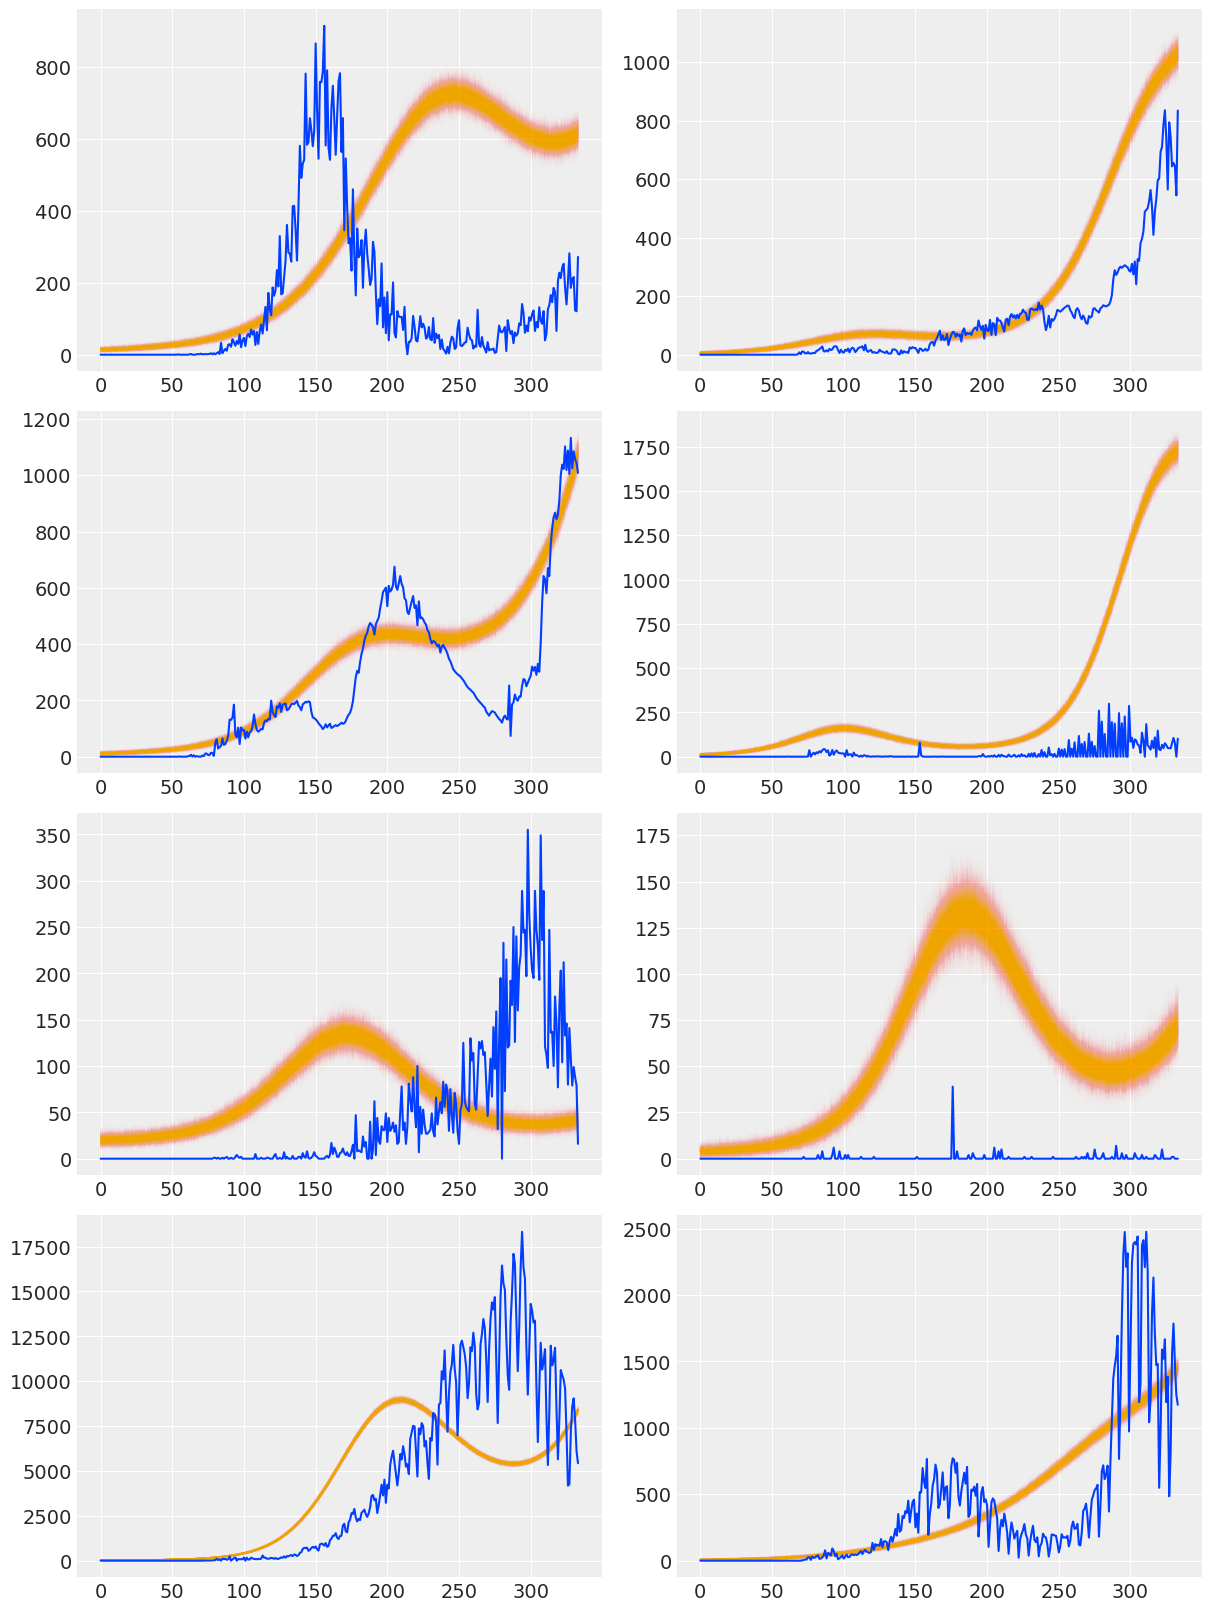

In [136]:
visualize_fit(groups, m.pred_samples_fit, 8)

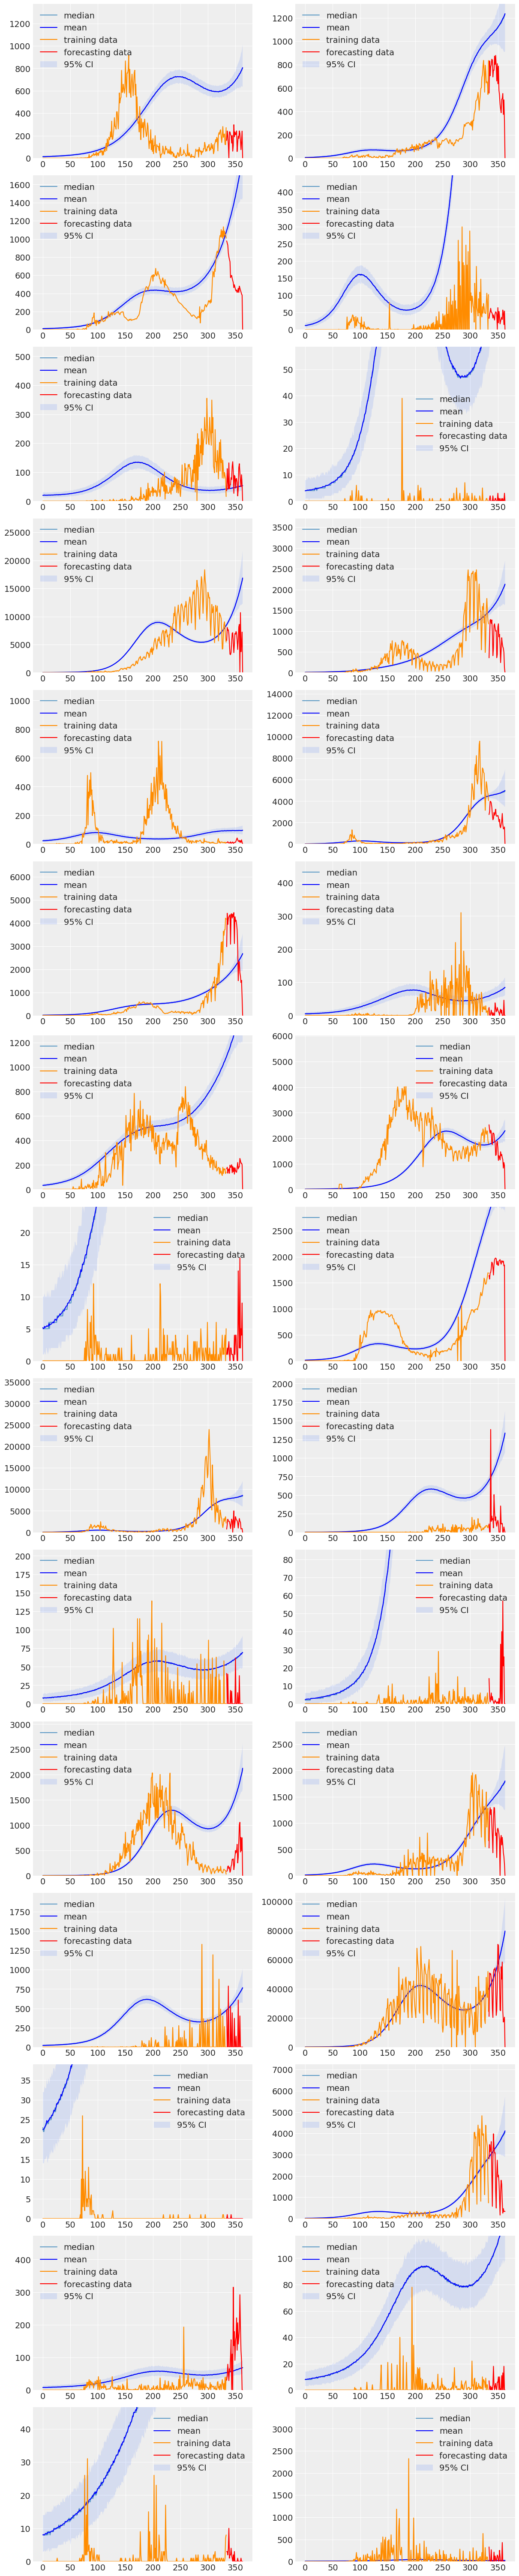

In [131]:
visualize_predict(groups, m.pred_samples_predict, 30)

In [133]:
results = calculate_metrics(m.pred_samples_predict, groups)

In [134]:
metrics_to_table(groups, results)

,bottom,total,Continent,UN_region,UNICEF_region,WHO_region,MDG_region,income,all
mase,45.445,16.033,7.59,6.258,8.294,8.669,7.272,9.069,44.308
rmse,2697.259,346063.278,59747.652,18425.332,44868.439,60923.649,32817.114,87141.649,15976.608
